In [3]:
from imblearn.pipeline import make_pipeline
from imblearn import datasets
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, roc_auc_score, classification_report, confusion_matrix 
from sklearn.model_selection import StratifiedKFold
from functions import *
# 
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv('final.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Calculate the row mean of non-missing values and check if it's greater than 0.3
row_condition = df.apply(lambda row: row.count() / len(row) > 0.3, axis=1)

# Calculate the column mean of non-missing values and check if it's greater than 0.3
col_condition = df.apply(lambda col: col.count() / len(col) > 0.3, axis=0)

# Use boolean indexing to subset the DataFrame based on the conditions
df = df.loc[row_condition, col_condition]
df.isna().sum()

fyear                           0
FFInd                           0
nopat                        2836
noa                         23087
roic                        23445
operatingprofit_margin       8254
turnover                    23318
netprofit_margin             7881
grossprofit_margin           7877
ROA                          2826
ROE                          2723
Ebitda_margin               11239
ebit_ta_ratio                3201
ebitda_ta_ratio              6207
deltappe                    16990
adjustedni                  18887
CFO                         34495
Netinvestment               20955
cfo_netinvestratio          36712
Current_ratio               23202
Quick_ratio                 24011
cash_ratio                  23648
wc_ta_ratio                 23551
deltacogs                   17149
lt_revt_ratio                7575
Operating_Cycle             28394
opex_lct                    23107
opex_lt                      2796
re_ta                        3266
average_invent

In [33]:
import pandas as pd

# Assuming df is your DataFrame
# Group by 'fyear' and sum the 'bankrupt' column
bankruptcies_per_year = df.groupby('fyear')['bankrupt'].sum().reset_index()

# This gives you a DataFrame with two columns: 'fyear' and the sum of bankruptcies for that year


In [34]:
bankruptcies_per_year

,fyear,bankrupt
0,1999,0
1,2000,0
2,2001,0
3,2002,0
4,2003,23
5,2004,49
6,2005,39
7,2006,34
8,2007,57
9,2008,95


In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights='distance', metric='nan_euclidean')
df_imputed = imputer.fit_transform(df)

In [162]:
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df_imputed.to_csv('imputed.csv', index=False)

In [4]:
df3 = pd.read_csv('endelig.csv')
df3 = df3.sort_values(by='fyear')
df3_filtered = df3[(df3['fyear'] >= 2003) & (df3['fyear'] < 2021)]
df3_filtered = df3_filtered.drop('...1', axis=1)

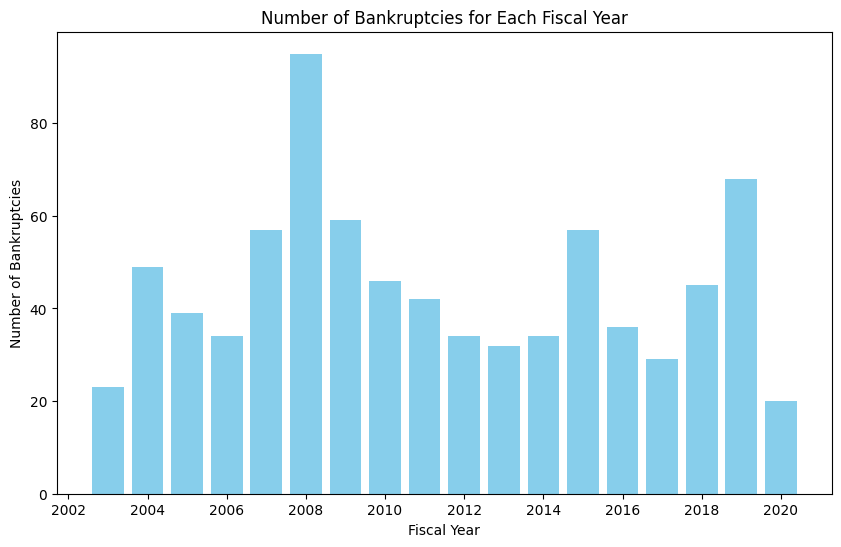

In [872]:
import matplotlib.ticker as ticker

# Your grouping code
grouped_df = df3_filtered[df3_filtered['bankrupt'] == 1].groupby('fyear').size().reset_index(name='count')

# Ensure 'fyear' is an integer AFTER grouping
grouped_df['fyear'] = grouped_df['fyear'].astype(int)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['fyear'], grouped_df['count'], color='skyblue')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Bankruptcies')
plt.title('Number of Bankruptcies for Each Fiscal Year')

# Set x-axis major ticker to integer format
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

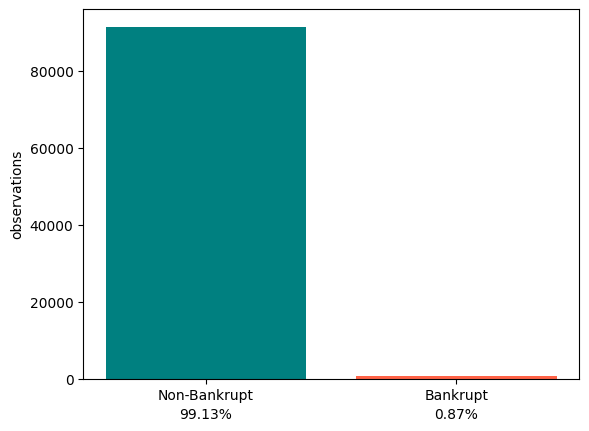

Number of non-bankrupt observations: 91547
Number of bankrupt observations: 799
The ratio of bankrupt instances: % 0.865224265263249


In [5]:
import numpy as np
import matplotlib.pyplot as plt

y = df3_filtered['bankrupt']
X = df3_filtered.drop('bankrupt', axis=1)

unique, counts = np.unique(y, return_counts=True)
percentages = 100 * counts / counts.sum()
colors = ['tomato' if label == 1 else 'teal' for label in unique]

plt.bar(unique, counts, color=colors)
plt.xticks([0, 1], ['Non-Bankrupt', 'Bankrupt'])

# Adding percentage text below the x-ticks
for i in range(len(unique)):
    plt.text(unique[i], -0.08*max(counts), f'{percentages[i]:.2f}%', ha='center', va='top')

plt.ylabel('observations')
plt.show()

print('Number of non-bankrupt observations:', counts[0])
print('Number of bankrupt observations:', counts[1])
print('The ratio of bankrupt instances: %', 100 * (counts[1] / (counts[0] + counts[1])))


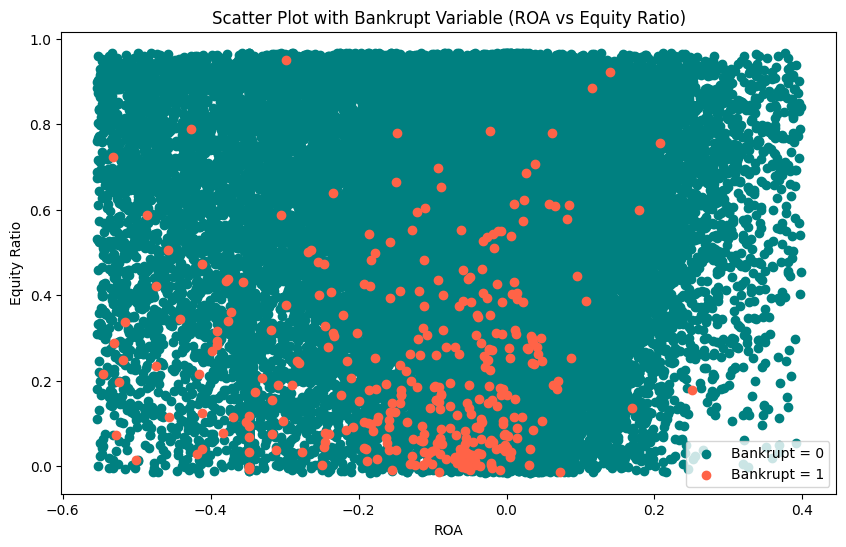

In [666]:
# Assuming 'ROA' and 'Equity_Ratio' are columns in your dataframe
df3_filtered['Feature1'] = df3_filtered['ROA']
df3_filtered['Feature2'] = df3_filtered['equity_ratio']

# Applying the 90% interval filtering as before
q_low = df3_filtered[['Feature1', 'Feature2']].quantile(0.1)
q_high = df3_filtered[['Feature1', 'Feature2']].quantile(0.99)

filtered_df = df3_filtered[(df3_filtered['Feature1'].between(q_low['Feature1'], q_high['Feature1'])) &
                 (df3_filtered['Feature2'].between(q_low['Feature2'], q_high['Feature2']))]

# Scatter plot for the updated data
plt.figure(figsize=(10, 6))
for i in [0, 1]:
    subset = filtered_df[filtered_df['bankrupt'] == i]
    plt.scatter(subset['Feature1'], subset['Feature2'], c=colors[i], label=f'Bankrupt = {i}')
plt.xlabel('ROA')
plt.ylabel('Equity Ratio')
plt.title('Scatter Plot with Bankrupt Variable (ROA vs Equity Ratio)')
plt.legend()
plt.show()


In [661]:
q_high

Feature1    0.398385
Feature2    0.967619
Name: 0.99, dtype: float64

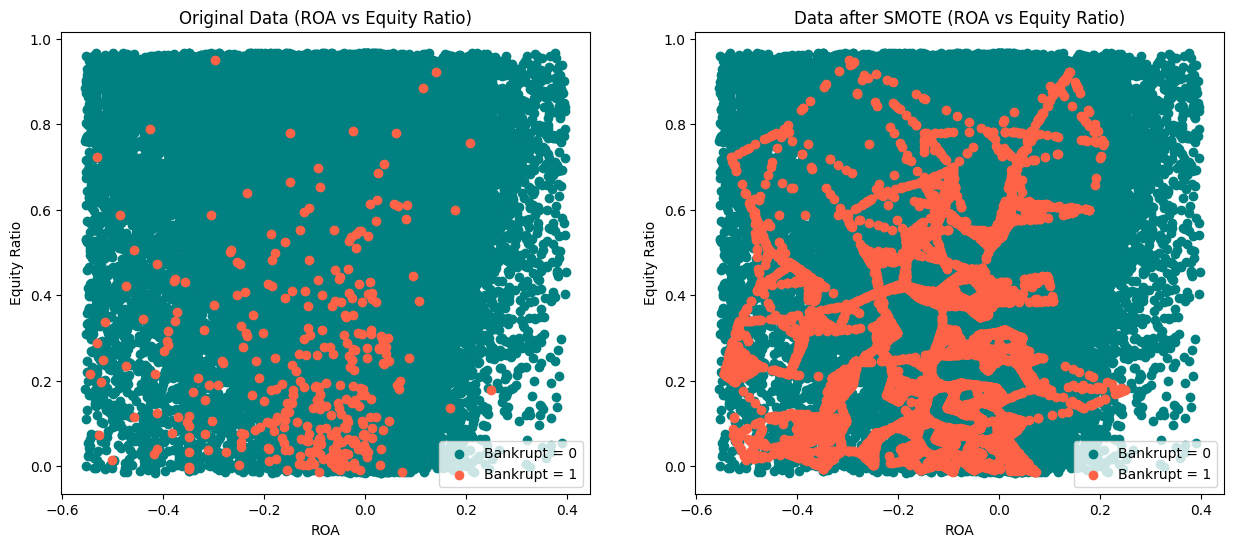

In [667]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Assuming df3_filtered is your original dataframe

# Original Scatter Plot
plt.figure(figsize=(15, 6))

# Plot 1: Original Data
plt.subplot(1, 2, 1)
for i in [0, 1]:
    subset = filtered_df[filtered_df['bankrupt'] == i]
    plt.scatter(subset['Feature1'], subset['Feature2'], c=colors[i], label=f'Bankrupt = {i}')
plt.xlabel('ROA')
plt.ylabel('Equity Ratio')
plt.title('Original Data (ROA vs Equity Ratio)')
plt.legend()

# Applying SMOTE
smote = SMOTE(sampling_strategy=0.15) # Adjust the sampling_strategy to 15% of the majority class
X_smote, y_smote = smote.fit_resample(filtered_df[['Feature1', 'Feature2']], filtered_df['bankrupt'])

# Creating a new DataFrame from the SMOTE output
smote_df = pd.DataFrame(X_smote, columns=['Feature1', 'Feature2'])
smote_df['bankrupt'] = y_smote

# Plot 2: Data after SMOTE
plt.subplot(1, 2, 2)
for i in [0, 1]:
    subset = smote_df[smote_df['bankrupt'] == i]
    plt.scatter(subset['Feature1'], subset['Feature2'], c=colors[i], label=f'Bankrupt = {i}')
plt.xlabel('ROA')
plt.ylabel('Equity Ratio')
plt.title('Data after SMOTE (ROA vs Equity Ratio)')
plt.legend()

plt.show()


In [14]:
from sklearn.model_selection import train_test_split
y = df3_filtered['bankrupt']
columns_to_drop = ['bankrupt', 'Unemployment.Rate', 'Trade.Balance', 'Inflation..annual...', 'GDP.growth..annual...', 'GDP.per.Capita..current.US.', 'Consumer.Credit', 'Negative', 'Positive', 'Litigious', 'Uncertainty', 'Constraining', 'StrongModal', 'WeakModal']
X = df3_filtered.drop(columns_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=False,)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('Train: 0=%.3f%%, 1=%.3f%%, Test: 0=%.3f%%, 1=%.3f%%' % (train_0/len(y_train)*100, train_1/len(y_train)*100, test_0/len(y_test)*100, test_1/len(y_test)*100))

Train: 0=73236, 1=640, Test: 0=18311, 1=159
Train: 0=99.134%, 1=0.866%, Test: 0=99.139%, 1=0.861%


In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import brier_score_loss
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a baseline random classifier
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Fit the baseline classifier on the training data
dummy_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy_clf.predict(X_test)

probs = dummy_clf.predict_proba(X_test)
probs = probs[:, 1]
brier_score = brier_score_loss(y_test, probs)

brier_score


0.016946399566865188

In [584]:

from sklearn.metrics import recall_score, precision_score, fbeta_score, brier_score_loss, roc_auc_score

# Create an empty DataFrame
columns = ['Model', 'AUC', 'Precision', 'Recall', 'F2', 'Brier Score']
score = pd.DataFrame(columns=columns)

# Function to compute and add scores for a model
def model_scores(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    Recall = recall_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

   
    probs = model.predict_proba(X_test)
    probs = probs[:,1] 
    auc = roc_auc_score(y_test, probs)

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    brier_score = brier_score_loss(y_test, probs)

    model_scores = pd.DataFrame(data=[[model_name, auc, Precision, Recall, f2, brier_score]], columns=columns)
    return model_scores

In [586]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

f2_scorer = make_scorer(fbeta_score, beta=2)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}

time_fold = TimeSeriesSplit(n_splits=5)

pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["FFInd", "fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



model_ratio = grid_search.fit(X_train, y_train)
cv_score = model_ratio.best_score_
test_score = model_ratio.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

model_ratio_scores = model_scores(model_ratio, X_test, y_test, 'Model with financial ratios')
score = pd.concat([score, model_ratio_scores], ignore_index=True)
score


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Cross-validation score: 0.3010572358046767
Test score: 0.31011450381679395
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.5}
Best score: 0.3010572358046767


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.882554,0.157767,0.408805,0.310115,0.018039


In [587]:

columns_to_drop = ['bankrupt', 'Unemployment.Rate', 'Trade.Balance', 'Inflation..annual...', 'GDP.growth..annual...', 'GDP.per.Capita..current.US.', 'Consumer.Credit']
X = df3_filtered.drop(columns_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=False,)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('Train: 0=%.3f%%, 1=%.3f%%, Test: 0=%.3f%%, 1=%.3f%%' % (train_0/len(y_train)*100, train_1/len(y_train)*100, test_0/len(y_test)*100, test_1/len(y_test)*100))

Train: 0=73236, 1=640, Test: 0=18311, 1=159
Train: 0=99.134%, 1=0.866%, Test: 0=99.139%, 1=0.861%


In [ ]:

# plot impact of brier score with imbalanced datasets
from sklearn.metrics import brier_score_loss
from matplotlib import pyplot
from numpy import array
# define an imbalanced dataset
testy = [0 for x in range(100)] + [1 for x in range(10)]
# brier score for predicting different fixed probability values
predictions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
losses = [brier_score_loss(testy, [y for x in range(len(testy))]) for y in predictions]
# plot predictions vs loss
pyplot.plot(predictions, losses)
pyplot.show()

In [588]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

f2_scorer = make_scorer(fbeta_score, beta=2)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}


pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["FFInd", "fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



model_text = grid_search.fit(X_train, y_train)
cv_score = model_text.best_score_
test_score = model_text.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

model_text_scores = model_scores(model_text, X_test, y_test, 'Model with textual data')
score = pd.concat([score, model_text_scores], ignore_index=True)
score


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Cross-validation score: 0.29488898680434744
Test score: 0.3311965811965812
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 50, 'classifier__subsample': 0.7}
Best score: 0.29488898680434744


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.882554,0.157767,0.408805,0.310115,0.018039
1,Model with textual data,0.887540,0.206667,0.389937,0.331197,0.015390


In [1]:

columns_to_drop = ['bankrupt']
X = df3_filtered.drop(columns_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=False)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('Train: 0=%.3f%%, 1=%.3f%%, Test: 0=%.3f%%, 1=%.3f%%' % (train_0/len(y_train)*100, train_1/len(y_train)*100, test_0/len(y_test)*100, test_1/len(y_test)*100))

NameError: name 'df3_filtered' is not defined

In [893]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

f2_scorer = make_scorer(fbeta_score, beta=2)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}
time_fold = TimeSeriesSplit(n_splits=5)


pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["FFInd", "fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search1 = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



model_macro = grid_search1.fit(X_train, y_train)
cv_score = model_macro.best_score_
test_score = model_macro.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search1.best_params_)
print('Best score:', grid_search1.best_score_)

model_macro_scores = model_scores(model_macro, X_test, y_test, 'Model with macro data')
score = pd.concat([score, model_macro_scores], ignore_index=True)
score

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Cross-validation score: 0.30296914933512104
Test score: 0.33210332103321033
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.5}
Best score: 0.30296914933512104


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.882554,0.157767,0.408805,0.310115,0.018039
1,Model with textual data,0.887540,0.206667,0.389937,0.331197,0.015390
2,Model with macro data,0.902626,0.160714,0.452830,0.332103,0.019830
3,SHAP-40,0.899727,0.141414,0.440252,0.309461,0.021573
4,SHAP-20,0.897445,0.153425,0.352201,0.279720,0.018523
5,Model with macro data,0.902626,0.160714,0.452830,0.332103,0.019830


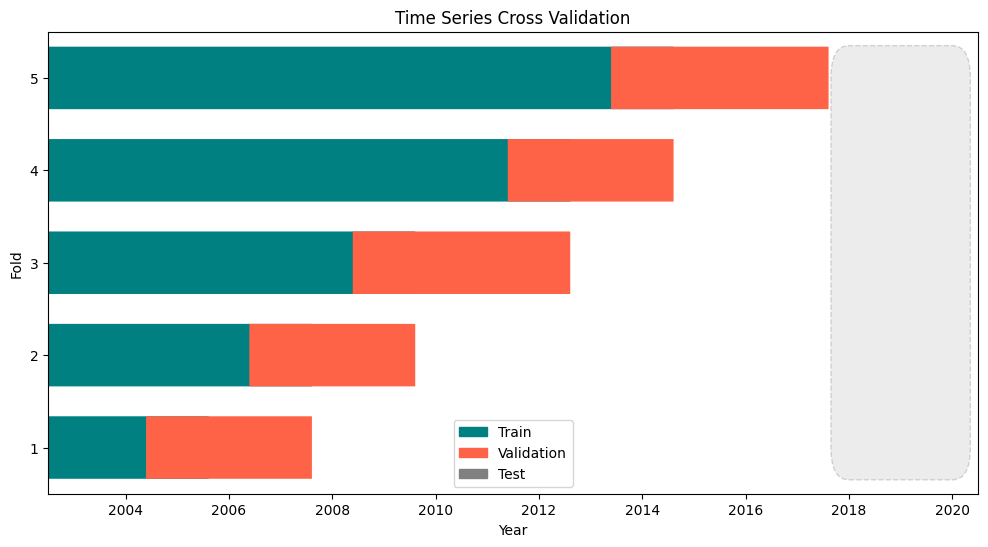

In [896]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import TimeSeriesSplit

# Assuming X_train is your training data and time_fold is your TimeSeriesSplit instance

time_fold = TimeSeriesSplit(n_splits=5)

# Assuming 'fyear' is a column in X_train
years = X['fyear']

# Plot Time Series Split with thicker bars and legend for train and validation
plt.figure(figsize=(12, 6))
for i, (train_idx, val_idx) in enumerate(time_fold.split(X_train, y_train), start = 1):
    plt.plot(years.iloc[train_idx], [i] * len(train_idx), linewidth=45, label='Train', color='teal')
    plt.plot(years.iloc[val_idx], [i] * len(val_idx),  linewidth=45, label='Validation', color='tomato')

# Create a custom shape for the testing area with rounded edges and divided lines
test_area = patches.FancyBboxPatch((2018, 1), 2020-2018, 4, boxstyle="round,pad=0.35", edgecolor='black', facecolor='gray', linewidth=1, linestyle='dashed', alpha=0.15)
plt.gca().add_patch(test_area)

# Manually create colored legend labels with background colors
legend_labels = [
    patches.Patch(color='teal', label='Train'),
    patches.Patch(color='tomato', label='Validation'),
    patches.Patch(color='grey', label='Test')
]

# Add a custom legend with colored background labels
plt.legend(handles=legend_labels, loc='best')
plt.ylim(0.5, 5.5)
plt.xlim(2002.5, 2020.5)
plt.title('Time Series Cross Validation')
plt.xlabel('Year')
plt.ylabel('Fold')
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

[02:28:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


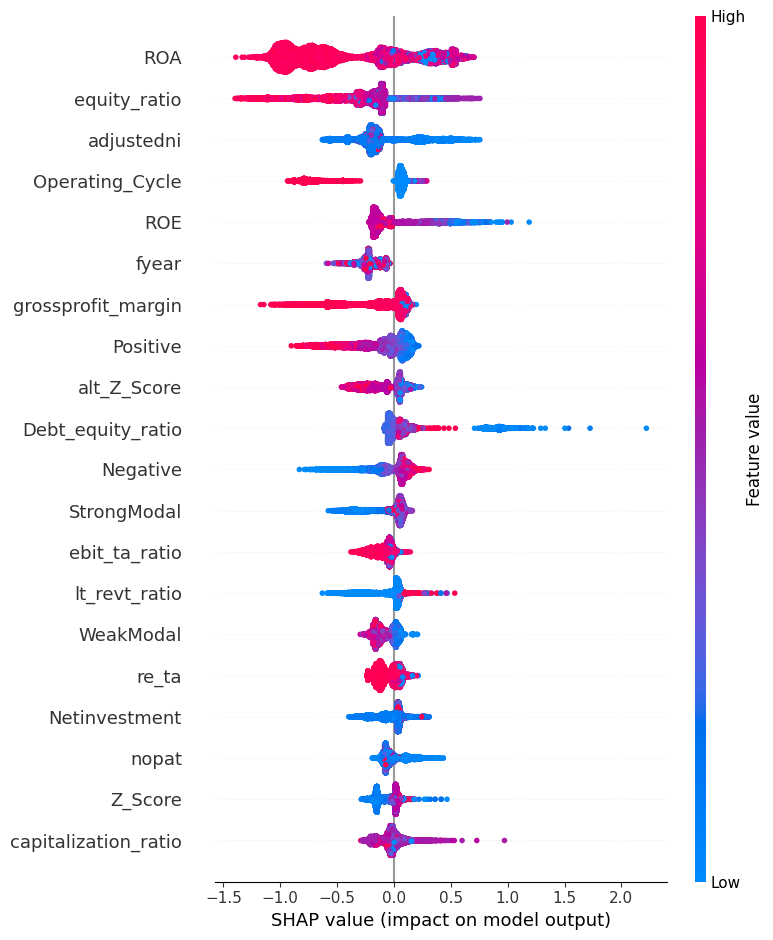

In [918]:
import shap

# Assuming 'best_model' is the best model obtained from your grid search
best_model = grid_search1.best_estimator_

# Assuming X_test is your test data
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=20)



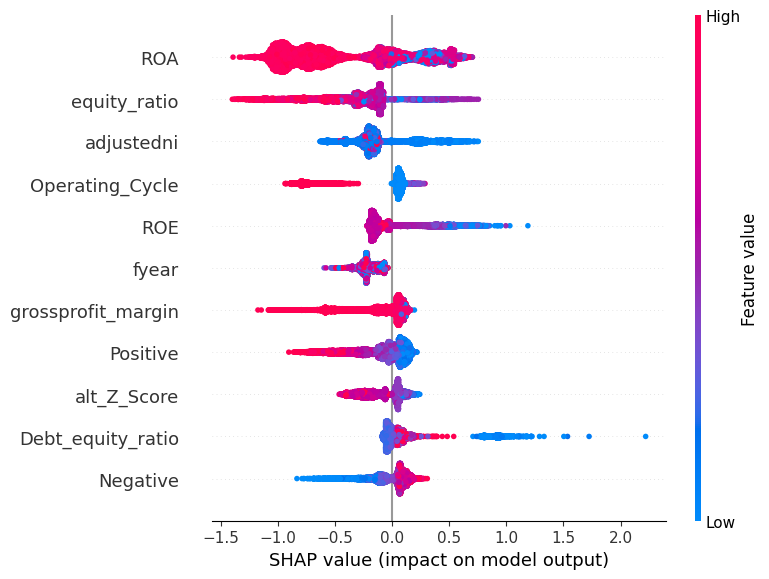

In [ ]:
# Visualize the summary plot or other SHAP visualizations
shap.summary_plot(shap_values, X_test, max_display=20)

In [596]:
# Identify the top 20 features based on absolute mean SHAP values
top_features_idx = (-np.abs(shap_values).mean(0)).argsort()[:40]
top_features = X.columns[top_features_idx]

# Create a new model using only the top 20 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [599]:

xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}

time_fold = TimeSeriesSplit(n_splits=5)

pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["FFInd", "fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



Shap_40 = grid_search.fit(X_train_top, y_train)
cv_score = Shap_40.best_score_
test_score = Shap_40.score(X_test_top, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Shap_40_scores = model_scores(Shap_40, X_test_top, y_test, 'SHAP-40')
score = pd.concat([score, Shap_40_scores], ignore_index=True)
score


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Cross-validation score: 0.30179822586526034
Test score: 0.3094606542882405
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.7}
Best score: 0.30179822586526034


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.882554,0.157767,0.408805,0.310115,0.018039
1,Model with textual data,0.887540,0.206667,0.389937,0.331197,0.015390
2,Model with macro data,0.902626,0.160714,0.452830,0.332103,0.019830
3,SHAP-40,0.899727,0.141414,0.440252,0.309461,0.021573


In [600]:
# Identify the top 20 features based on absolute mean SHAP values
top_features_idx = (-np.abs(shap_values).mean(0)).argsort()[:20]
top_features = X.columns[top_features_idx]

# Create a new model using only the top 20 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [601]:
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}

time_fold = TimeSeriesSplit(n_splits=5)

pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



Shap_20 = grid_search.fit(X_train_top, y_train)
cv_score = Shap_20.best_score_
test_score = Shap_20.score(X_test_top, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Shap_20_scores = model_scores(Shap_20, X_test_top, y_test, 'SHAP-20')
score = pd.concat([score, Shap_20_scores], ignore_index=True)
score

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Cross-validation score: 0.30261137214509076
Test score: 0.27972027972027974
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 50, 'classifier__subsample': 0.5}
Best score: 0.30261137214509076


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.882554,0.157767,0.408805,0.310115,0.018039
1,Model with textual data,0.887540,0.206667,0.389937,0.331197,0.015390
2,Model with macro data,0.902626,0.160714,0.452830,0.332103,0.019830
3,SHAP-40,0.899727,0.141414,0.440252,0.309461,0.021573
4,SHAP-20,0.897445,0.153425,0.352201,0.279720,0.018523


In [7]:
columns = ['Model', 'AUC', 'Precision', 'Recall', 'F2', 'Brier Score']
score_industry = pd.DataFrame(columns=columns)

In [8]:
df = pd.read_csv('total_industry_petroleum.csv')
df = df.sort_values(by='fyear')
df = df[(df['fyear'] >= 2007) & (df['fyear'] < 2021)]

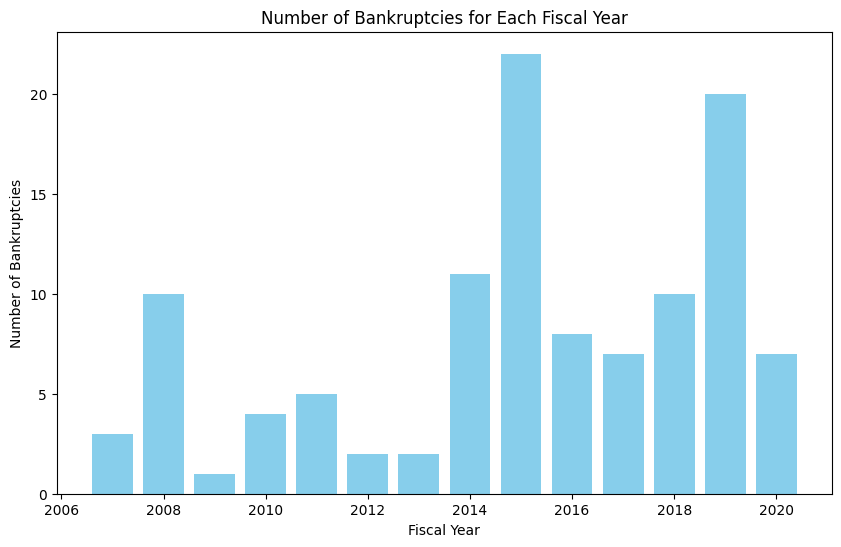

In [848]:
import matplotlib.ticker as ticker

# Your grouping code
grouped_df = df[df['bankrupt'] == 1].groupby('fyear').size().reset_index(name='count')

# Ensure 'fyear' is an integer AFTER grouping
grouped_df['fyear'] = grouped_df['fyear'].astype(int)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['fyear'], grouped_df['count'], color='skyblue')
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Bankruptcies')
plt.title('Number of Bankruptcies for Each Fiscal Year')

# Set x-axis major ticker to integer format
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

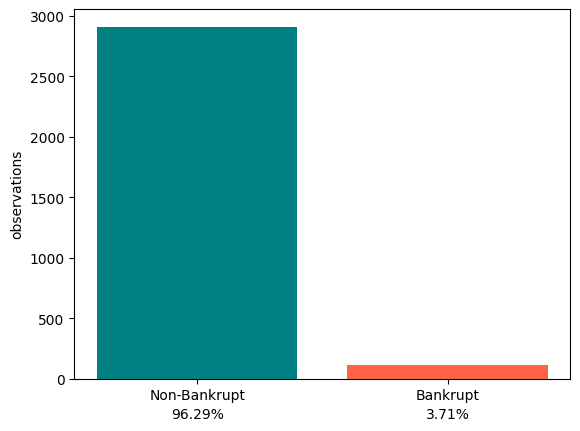

Number of non-bankrupt observations: 2909
Number of bankrupt observations: 112
The ratio of bankrupt instances: % 3.7073816617014232


In [23]:
import numpy as np
import matplotlib.pyplot as plt

y = df['bankrupt']
X = df.drop('bankrupt', axis=1)

unique, counts = np.unique(y, return_counts=True)
percentages = 100 * counts / counts.sum()
colors = ['tomato' if label == 1 else 'teal' for label in unique]

plt.bar(unique, counts, color=colors)
plt.xticks([0, 1], ['Non-Bankrupt', 'Bankrupt'])

# Adding percentage text below the x-ticks
for i in range(len(unique)):
    plt.text(unique[i], -0.08*max(counts), f'{percentages[i]:.2f}%', ha='center', va='top')

plt.ylabel('observations')
plt.show()

print('Number of non-bankrupt observations:', counts[0])
print('Number of bankrupt observations:', counts[1])
print('The ratio of bankrupt instances: %', 100 * (counts[1] / (counts[0] + counts[1])))

In [29]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

time_fold = TimeSeriesSplit(n_splits=5)
# Create a baseline random classifier
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Fit the baseline classifier on the training data
dummy_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy_clf.predict(X_test)

probs = dummy_clf.predict_proba(X_test)
probs = probs[:, 1]
brier_score = brier_score_loss(y_test, probs)

brier_score


0.0859504132231405

In [852]:
from sklearn.model_selection import train_test_split
y = df['bankrupt']
columns_to_drop = ['bankrupt', 'FFInd','Unemployment.Rate', 'Trade.Balance', 'Inflation..annual...', 'GDP.growth..annual...', 'GDP.per.Capita..current.US.', 'Consumer.Credit', 'Negative', 'Positive', 'Litigious', 'Uncertainty', 'Constraining', 'StrongModal', 'WeakModal',
                   'annualized_volatility_SP','SP_Close', 'log_returns_SP', 'annualized_volatility_WTI', 'Rig_oil_us', 'WTC/WTI(mid_price)']
X = df.drop(columns_to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,                                                    
                                                    shuffle=False)
                                                    

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('Train: 0=%.3f%%, 1=%.3f%%, Test: 0=%.3f%%, 1=%.3f%%' % (train_0/len(y_train)*100, train_1/len(y_train)*100, test_0/len(y_test)*100, test_1/len(y_test)*100))

Train: 0=2343, 1=73, Test: 0=566, 1=39
Train: 0=96.978%, 1=3.022%, Test: 0=93.554%, 1=6.446%


In [853]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

f2_scorer = make_scorer(fbeta_score, beta=2)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150], 
    'classifier__max_depth': [4, 5, 6, 7],  
    'classifier__min_child_weight': [1, 2, 3],  
    'classifier__learning_rate': [0.1, 0.2, 0.3],  
    'classifier__subsample': [0.5, 0.7, 1],
}

time_fold = TimeSeriesSplit(n_splits=3)

pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



model_ratio_ind = grid_search.fit(X_train, y_train)
cv_score = model_ratio_ind.best_score_
test_score = model_ratio_ind.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

model_ratio_ind_scores = model_scores(model_ratio_ind, X_test, y_test, 'Model with financial ratios')
score_industry = pd.concat([score_industry, model_ratio_ind_scores], ignore_index=True)
score_industry

Fitting 3 folds for each of 324 candidates, totalling 972 fits


Cross-validation score: 0.289368930373014
Test score: 0.1506024096385542
Best parameters: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 7, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.5}
Best score: 0.289368930373014


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.855667,0.5,0.128205,0.150602,0.055721


In [854]:

columns_to_drop = ['bankrupt', 'FFInd', 'Unemployment.Rate', 'Trade.Balance', 'Inflation..annual...', 'GDP.growth..annual...', 'GDP.per.Capita..current.US.', 'Consumer.Credit',
                   'annualized_volatility_SP','SP_Close', 'log_returns_SP', 'annualized_volatility_WTI', 'Rig_oil_us', 'WTC/WTI(mid_price)']
X = df.drop(columns_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,                                                    
                                                    shuffle=False)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('Train: 0=%.3f%%, 1=%.3f%%, Test: 0=%.3f%%, 1=%.3f%%' % (train_0/len(y_train)*100, train_1/len(y_train)*100, test_0/len(y_test)*100, test_1/len(y_test)*100))

Train: 0=2343, 1=73, Test: 0=566, 1=39
Train: 0=96.978%, 1=3.022%, Test: 0=93.554%, 1=6.446%


In [855]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

f2_scorer = make_scorer(fbeta_score, beta=2)
time_fold = TimeSeriesSplit(n_splits=3)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}



pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



model_text_ind = grid_search.fit(X_train, y_train)
cv_score = model_text_ind.best_score_
test_score = model_text_ind.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

model_text_ind_scores = model_scores(model_text_ind, X_test, y_test, 'Model with textual data')
score_industry = pd.concat([score_industry, model_text_ind_scores], ignore_index=True)
score_industry

Fitting 3 folds for each of 324 candidates, totalling 972 fits


Cross-validation score: 0.33114117060710835
Test score: 0.20710059171597633
Best parameters: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 50, 'classifier__subsample': 0.5}
Best score: 0.33114117060710835


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.855667,0.500000,0.128205,0.150602,0.055721
1,Model with textual data,0.838271,0.538462,0.179487,0.207101,0.053467


In [856]:
columns_to_drop = ['bankrupt','FFInd','annualized_volatility_SP','SP_Close', 'log_returns_SP', 'annualized_volatility_WTI', 'Rig_oil_us', 'WTC/WTI(mid_price)']
X = df.drop(columns_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,                                                    
                                                    shuffle=False)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('Train: 0=%.3f%%, 1=%.3f%%, Test: 0=%.3f%%, 1=%.3f%%' % (train_0/len(y_train)*100, train_1/len(y_train)*100, test_0/len(y_test)*100, test_1/len(y_test)*100))

Train: 0=2343, 1=73, Test: 0=566, 1=39
Train: 0=96.978%, 1=3.022%, Test: 0=93.554%, 1=6.446%


In [857]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

f2_scorer = make_scorer(fbeta_score, beta=2)
time_fold = TimeSeriesSplit(n_splits=3)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}


pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



model_macro_ind = grid_search.fit(X_train, y_train)
cv_score = model_macro_ind.best_score_
test_score = model_macro_ind.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

model_macro_ind_scores = model_scores(model_macro_ind, X_test, y_test, 'Model with macro data')
score_industry = pd.concat([score_industry, model_macro_ind_scores], ignore_index=True)
score_industry

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Cross-validation score: 0.35908535908535905
Test score: 0.2793296089385474
Best parameters: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 7, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 50, 'classifier__subsample': 0.7}
Best score: 0.35908535908535905


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.855667,0.500000,0.128205,0.150602,0.055721
1,Model with textual data,0.838271,0.538462,0.179487,0.207101,0.053467
2,Model with macro data,0.867763,0.434783,0.256410,0.279330,0.057839


In [912]:
columns_to_drop = ['bankrupt','FFInd','annualized_volatility_SP','SP_Close', 'log_returns_SP']
X = df.drop(columns_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,                                                    
                                                    shuffle=False)

train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
print('Train: 0=%.3f%%, 1=%.3f%%, Test: 0=%.3f%%, 1=%.3f%%' % (train_0/len(y_train)*100, train_1/len(y_train)*100, test_0/len(y_test)*100, test_1/len(y_test)*100))

Train: 0=2343, 1=73, Test: 0=566, 1=39
Train: 0=96.978%, 1=3.022%, Test: 0=93.554%, 1=6.446%


In [913]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

f2_scorer = make_scorer(fbeta_score, beta=2)
time_fold = TimeSeriesSplit(n_splits=3)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}



pipeline = imbpipeline(steps=[
    ['smote', SMOTENC(random_state=11, sampling_strategy=0.15, categorical_features=["fyear"])],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



model_macro_ind2 = grid_search.fit(X_train, y_train)
cv_score = model_macro_ind2.best_score_
test_score = model_macro_ind2.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

model_macro_ind_scores2 = model_scores(model_macro_ind2, X_test, y_test, 'Model with Industry macro data')
score_industry = pd.concat([score_industry, model_macro_ind_scores2], ignore_index=True)
score_industry

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Cross-validation score: 0.34563573485729177
Test score: 0.32432432432432434
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 50, 'classifier__subsample': 1}
Best score: 0.34563573485729177


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.855667,0.500000,0.128205,0.150602,0.055721
1,Model with textual data,0.838271,0.538462,0.179487,0.207101,0.053467
2,Model with macro data,0.867763,0.434783,0.256410,0.279330,0.057839
3,Model with Industry macro data,0.878001,0.413793,0.307692,0.324324,0.053553
4,SHAP-40,0.885114,0.368421,0.179487,0.200000,0.055713
5,SHAP-20,0.881444,0.428571,0.230769,0.254237,0.055297
6,Model with Industry macro data,0.878001,0.413793,0.307692,0.324324,0.053553


[02:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


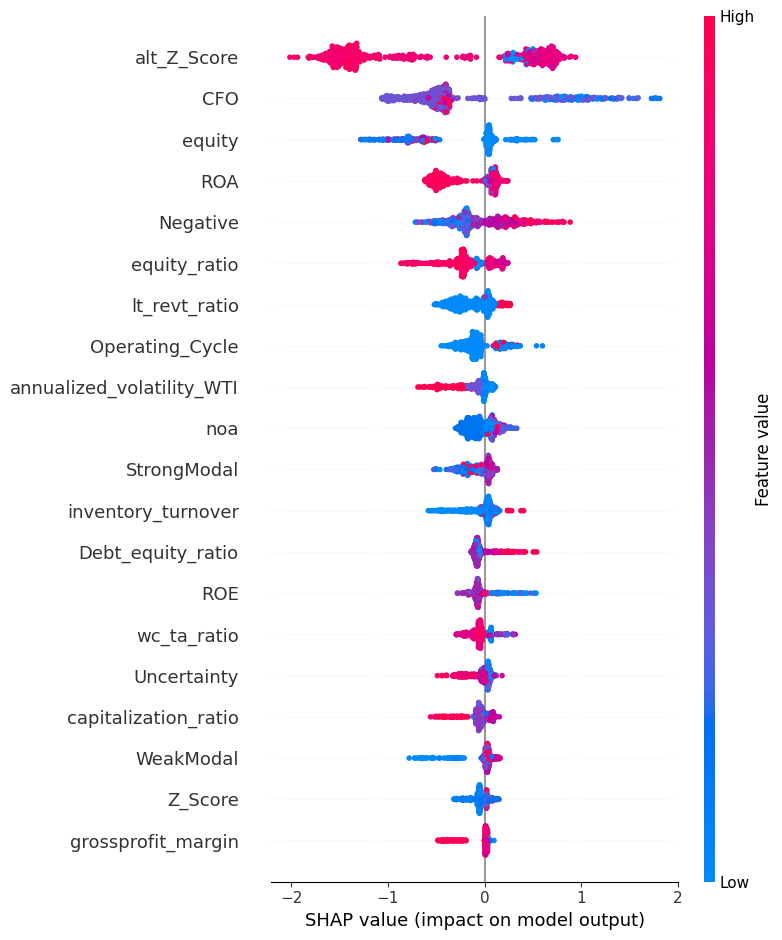

In [915]:
import shap

# Assuming 'best_model' is the best model obtained from your grid search
best_model = grid_search.best_estimator_

# Assuming X_test is your test data
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values2 = explainer.shap_values(X_test_ind)

# Visualize the summary plot or other SHAP visualizations
shap.summary_plot(shap_values2, X_test_ind, max_display=20)

In [905]:
explainer2 = shap.Explainer(model_macro_ind2.predict, X_test_ind)
shap_values2 = explainer2(X_test_ind)

PermutationExplainer explainer: 606it [00:36, 13.22it/s]                         


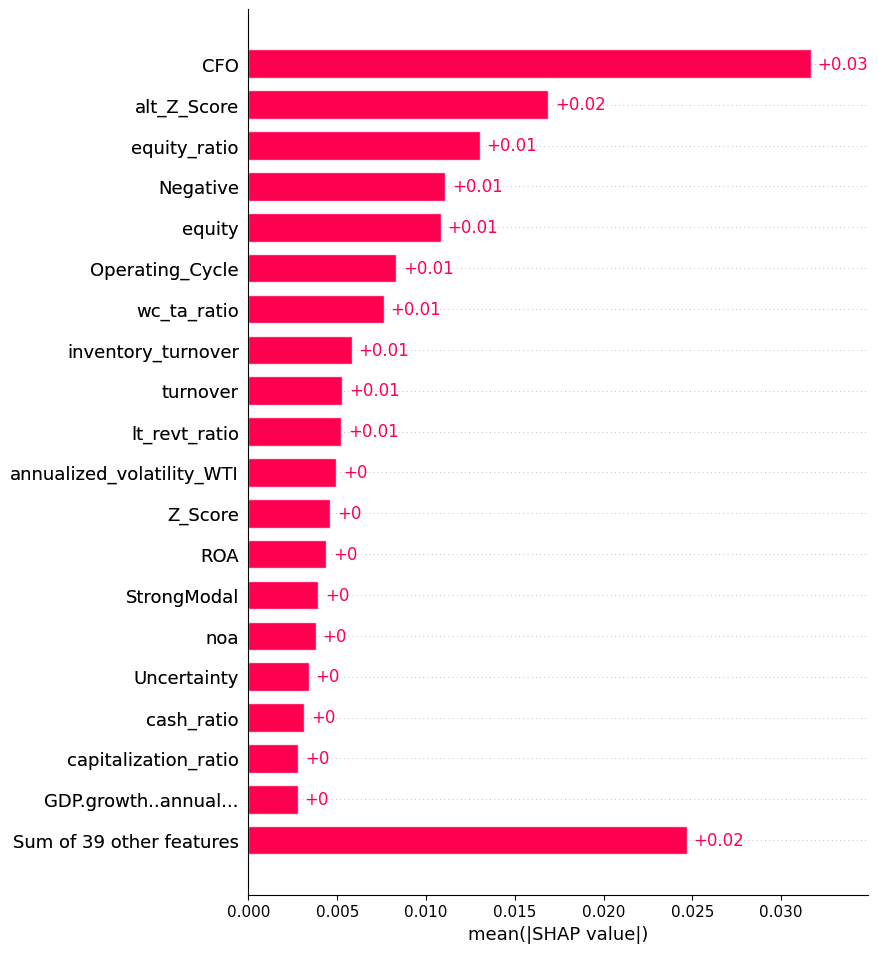

In [907]:
shap.plots.bar(shap_values2, max_display=20)


In [861]:
# Identify the top 20 features based on absolute mean SHAP values
top_features_idx = (-np.abs(shap_values2).mean(0)).argsort()[:40]
top_features = X.columns[top_features_idx]

# Create a new model using only the top 20 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [862]:
from imblearn.over_sampling import SMOTE
time_fold = TimeSeriesSplit(n_splits=3)
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}



pipeline = imbpipeline(steps=[
    ['smote', SMOTE(random_state=11, sampling_strategy=0.15)],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



Shap_40_ind = grid_search.fit(X_train_top, y_train)
cv_score = Shap_40_ind.best_score_
test_score = Shap_40_ind.score(X_test_top, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Shap_40_ind_scores = model_scores(Shap_40_ind, X_test_top, y_test, 'SHAP-40')
score_industry = pd.concat([score_industry, Shap_40_ind_scores], ignore_index=True)
score_industry

Fitting 3 folds for each of 324 candidates, totalling 972 fits


Cross-validation score: 0.35669807234134715
Test score: 0.2
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.5}
Best score: 0.35669807234134715


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.855667,0.500000,0.128205,0.150602,0.055721
1,Model with textual data,0.838271,0.538462,0.179487,0.207101,0.053467
2,Model with macro data,0.867763,0.434783,0.256410,0.279330,0.057839
3,Model with Industry macro data,0.878001,0.413793,0.307692,0.324324,0.053553
4,SHAP-40,0.885114,0.368421,0.179487,0.200000,0.055713


In [863]:
# Identify the top 20 features based on absolute mean SHAP values
top_features_idx = (-np.abs(shap_values2).mean(0)).argsort()[:20]
top_features = X.columns[top_features_idx]

# Create a new model using only the top 20 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [864]:
xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # default: 100
    'classifier__max_depth': [4, 5, 6, 7],  # default: 3
    'classifier__min_child_weight': [1, 2, 3],  # default: 1
    'classifier__learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'classifier__subsample': [0.5, 0.7, 1],
}

time_fold = TimeSeriesSplit(n_splits=3)
pipeline = imbpipeline(steps=[
    ['smote', SMOTE(random_state=11, sampling_strategy=0.15)],
    ['classifier', XGBClassifier(random_state=11, tree_method='hist', eval_metric='logloss')],
    ])



grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=xgb_param_grid,
                           scoring=f2_scorer,
                           cv=time_fold,
                           verbose=1,)



Shap_20_ind = grid_search.fit(X_train_top, y_train)
cv_score = Shap_20_ind.best_score_
test_score = Shap_20_ind.score(X_test_top, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Shap_20_ind_scores = model_scores(Shap_20_ind, X_test_top, y_test, 'SHAP-20')
score_industry = pd.concat([score_industry, Shap_20_ind_scores], ignore_index=True)
score_industry

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Cross-validation score: 0.36408144129663117
Test score: 0.2542372881355932
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 50, 'classifier__subsample': 1}
Best score: 0.36408144129663117


,Model,AUC,Precision,Recall,F2,Brier Score
0,Model with financial ratios,0.855667,0.500000,0.128205,0.150602,0.055721
1,Model with textual data,0.838271,0.538462,0.179487,0.207101,0.053467
2,Model with macro data,0.867763,0.434783,0.256410,0.279330,0.057839
3,Model with Industry macro data,0.878001,0.413793,0.307692,0.324324,0.053553
4,SHAP-40,0.885114,0.368421,0.179487,0.200000,0.055713
5,SHAP-20,0.881444,0.428571,0.230769,0.254237,0.055297


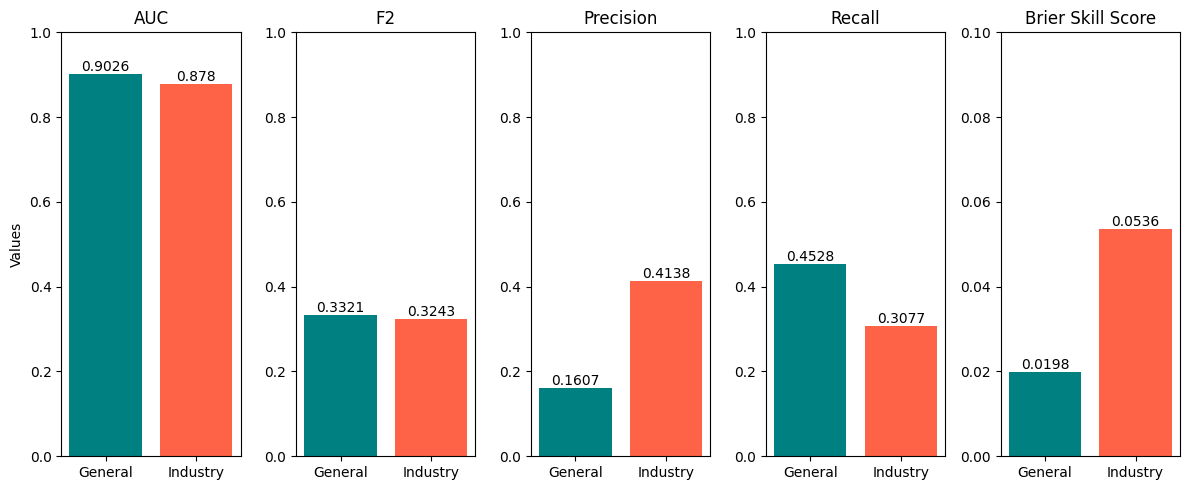

In [31]:
# Further modified code to allow for interchangeable x-axis labels for each plot

# Data
# Correcting the code based on the user's latest input

import matplotlib.pyplot as plt

# Data
categories = ['General', 'Industry']
values_list = [[0.9026, 0.8780], [0.3321, 0.3243],[0.1607, 0.4138], [0.4528, 0.3077], [0.0198, 0.0536]]

# Individual x-axis labels for each plot
x_labels = ['AUC', 'F2', 'Precision', 'Recall', 'Brier Skill Score']

# Creating the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 5))

for i, ax in enumerate(axes):
    bars = ax.bar(categories, values_list[i], color=['teal', 'tomato'])
    ax.set_title(x_labels[i])  # Setting individual x-axis labels
    if i == 0:
        ax.set_ylabel('Values')

    # Adjusting the y-axis range for the last plot
    if i == len(axes) - 1:
        ax.set_ylim(0, 0.1)
    else:
        ax.set_ylim(0, 1)

    ax.grid(False)

    # Adding the values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [869]:

X_test_ind = X_test.copy()
X_train_ind = X_train.copy()
y_test_ind = y_test.copy()
y_train_ind = y_train.copy()

In [875]:
y_pred_macro_ind2 = model_macro_ind2.predict(X_test_ind)
y_pred_macro = model_macro.predict(X_test)

In [876]:
cm_macro_ind2 = confusion_matrix(y_test_ind, y_pred_macro_ind2)
cm_macro = confusion_matrix(y_test, y_pred_macro)

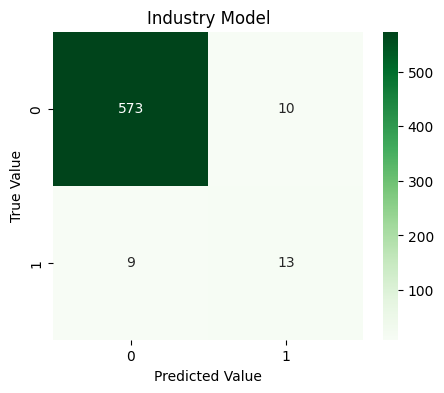

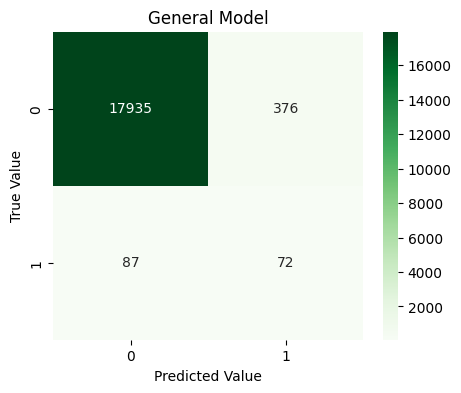

In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(f'{title}')
    plt.ylabel('True Value')
    plt.xlabel('Predicted Value')

# Plotting confusion matrix for model_macro_ind2
plot_confusion_matrix(cm_macro_ind2, 'Industry Model')

# Plotting confusion matrix for model_macro
plot_confusion_matrix(cm_macro, 'General Model')

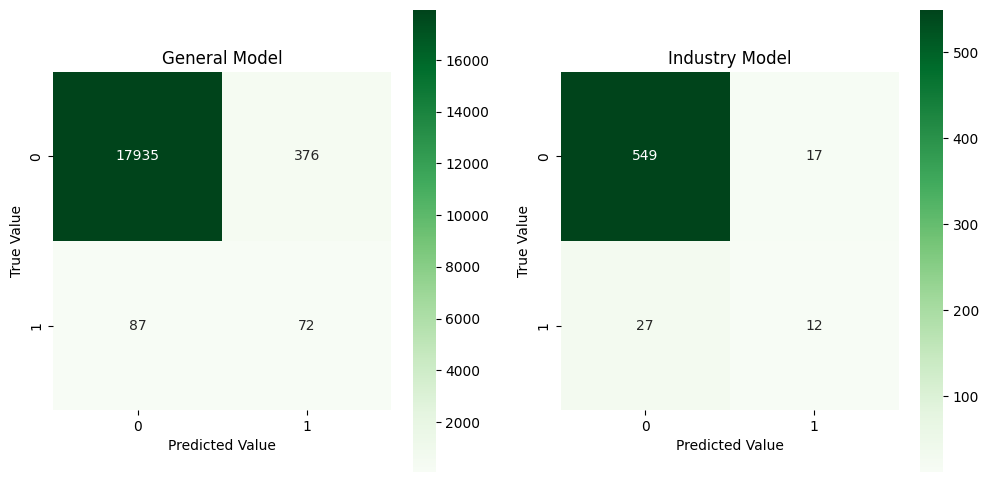

In [877]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, subplot, ylabel):
    ax = plt.subplot(subplot)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('True Value')
    ax.set_aspect('equal')

# Plotting both confusion matrices on the same plot with modifications
plt.figure(figsize=(12, 6))

# Swapping the places of the plots and adding ylabel only to the left plot
plot_confusion_matrix(cm_macro_ind2, 'Industry Model', 122, ylabel=True)
plot_confusion_matrix(cm_macro, 'General Model', 121, ylabel=False)

# Adding some spacing between the plots
plt.subplots_adjust(wspace=0.2)

plt.show()


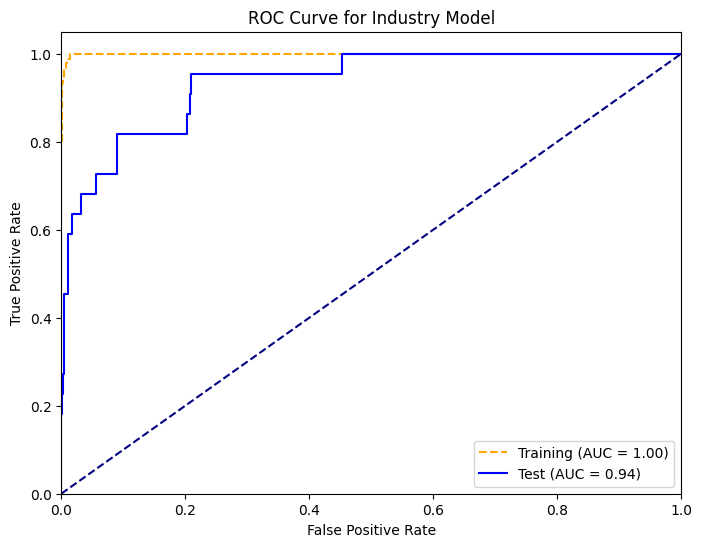

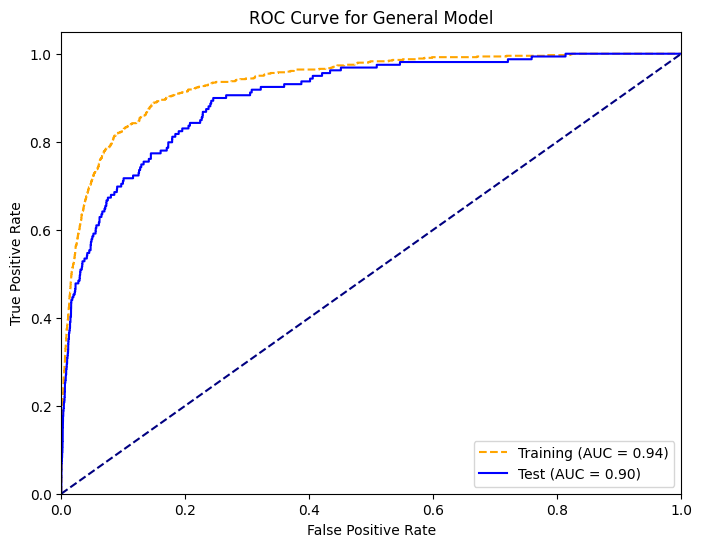

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming the following variables are defined:
# y_train, y_test: actual labels for training and test sets
# model_macro_ind2, model_macro: your trained models

# Function to plot ROC curve
def plot_roc_curve(model, X_train, y_train, X_test, y_test, model_name):
    # Probabilities for the positive class
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_test_probs = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and ROC area for training
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))

    # Plot training ROC curve
    plt.plot(fpr_train, tpr_train, color='orange', linestyle='--',
             label=f'Training (AUC = {roc_auc_train:.2f})')

    # Plot test ROC curve
    plt.plot(fpr_test, tpr_test, color='blue', 
             label=f'Test (AUC = {roc_auc_test:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for model_macro_ind2
plot_roc_curve(model_macro_ind2, X_train_ind, y_train_ind, X_test_ind, y_test_ind, 'Industry Model')

# Plot ROC curve for model_macro
plot_roc_curve(model_macro, X_train, y_train, X_test, y_test, 'General Model')


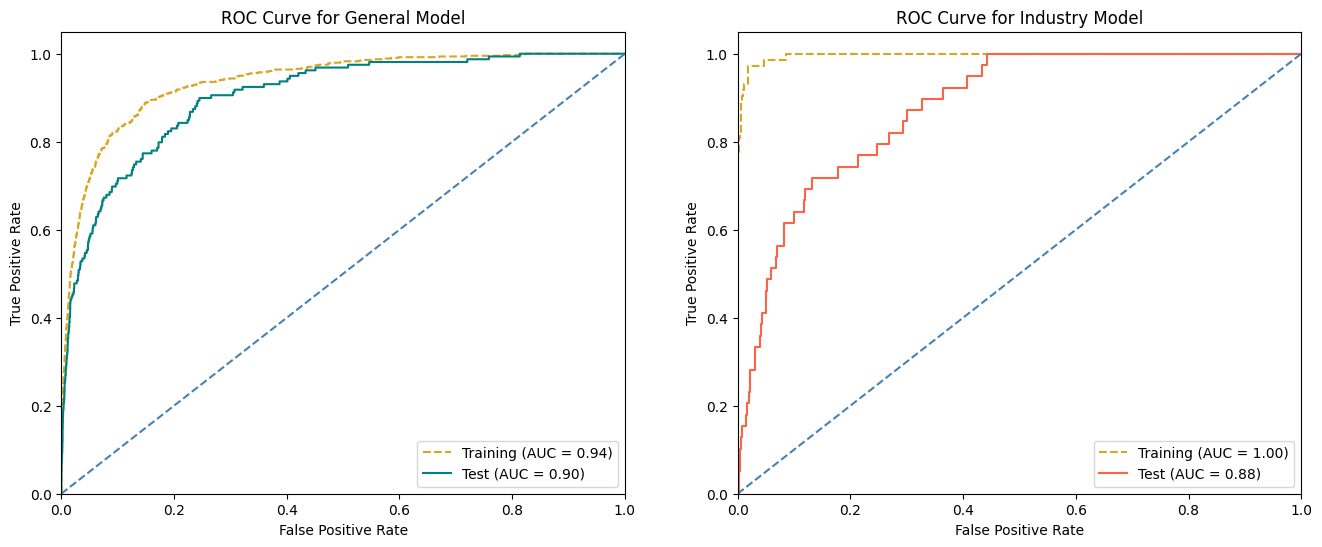

In [878]:
def plot_roc_curves(models, datasets, model_names):
    plt.figure(figsize=(16, 6))

    for i, (model, data, name) in enumerate(zip(models, datasets, model_names)):
        X_train, y_train, X_test, y_test = data
        y_train_probs = model.predict_proba(X_train)[:, 1]
        y_test_probs = model.predict_proba(X_test)[:, 1]

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
        roc_auc_train = auc(fpr_train, tpr_train)

        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
        roc_auc_test = auc(fpr_test, tpr_test)

        plt.subplot(1, 2, i + 1)

        if name == 'General Model':
            train_color, test_color = 'goldenrod', 'teal'
        elif name == 'Industry Model':
            train_color, test_color = 'goldenrod', 'tomato'

        plt.plot(fpr_train, tpr_train, color=train_color, linestyle='--',
                 label=f'Training (AUC = {roc_auc_train:.2f})')
        plt.plot(fpr_test, tpr_test, color=test_color, 
                 label=f'Test (AUC = {roc_auc_test:.2f})')

        plt.plot([0, 1], [0, 1], color='steelblue', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc="lower right")

    plt.show()

# Prepare the data for each model
data_industry = (X_train_ind, y_train_ind, X_test_ind, y_test_ind)
data_general = (X_train, y_train, X_test, y_test)

# Plot ROC curves for both models
plot_roc_curves([model_macro, model_macro_ind2], [data_general, data_industry], ['General Model', 'Industry Model'])


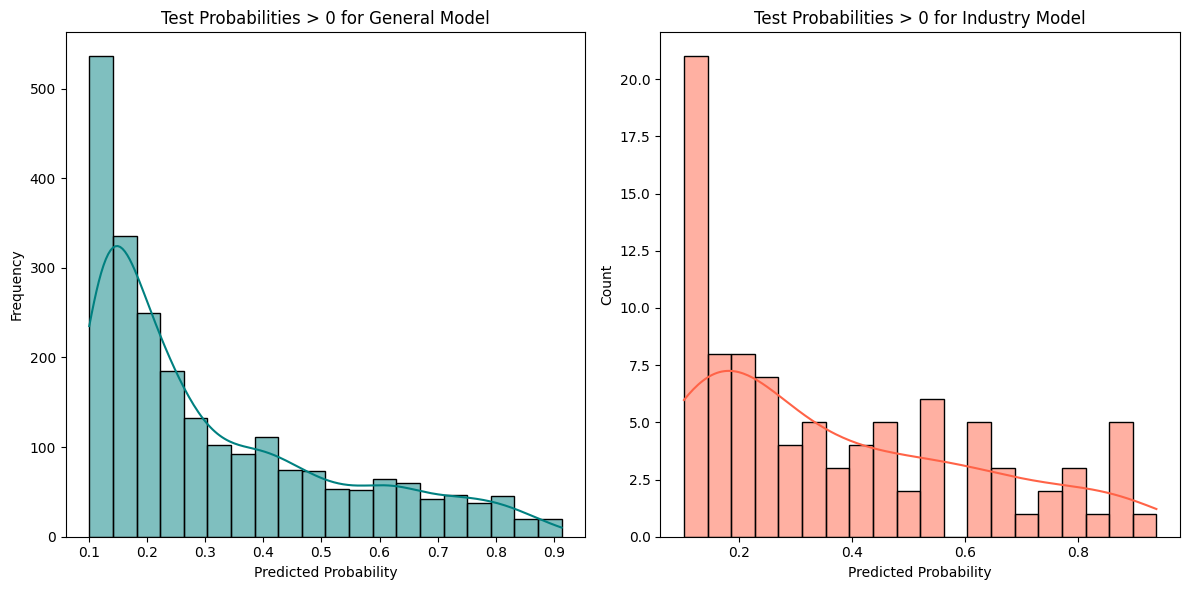

In [888]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_test_probability_distributions(model1, X_test1, model_name1, model2, X_test2, model_name2):
    # Getting the predicted probabilities for the positive class and filtering for values above 0
    test_probs1 = model1.predict_proba(X_test1)[:, 1]
    test_probs1 = test_probs1[test_probs1 > 0.1]  # Filter for probabilities greater than 0

    test_probs2 = model2.predict_proba(X_test2)[:, 1]
    test_probs2 = test_probs2[test_probs2 > 0.1]  # Filter for probabilities greater than 0

    plt.figure(figsize=(12, 6))

    # Plotting the test probabilities for the first model
    plt.subplot(1, 2, 1)
    sns.histplot(test_probs1, bins=20, kde=True, color='teal')
    plt.title(f'Test Probabilities > 0 for {model_name1}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')

    # Plotting the test probabilities for the second model
    plt.subplot(1, 2, 2)
    sns.histplot(test_probs2, bins=20, kde=True, color='tomato')
    plt.title(f'Test Probabilities > 0 for {model_name2}')
    plt.xlabel('Predicted Probability')

    plt.tight_layout()
    plt.show()

# Example usage
plot_test_probability_distributions(model_macro, X_test, 'General Model', model_macro_ind2, X_test_ind, 'Industry Model' )

